#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
%matplotlib inline

### Download the dataset from class, missing values imputed for you

In [2]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [3]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We itroduced Stochastic Gradien Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)^T$

2) Take a point $\tilde{x}^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})^T$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^T\tilde{x}^{(i)} - y^{(i)})^2 \qquad \text{ or }\quad (y^{(i)} - w^T\tilde{x}^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \eta\nabla Loss(a(x^{(i)}), y^{(i)}),
$$
where $\eta\in (0,1)$ is the learning rate.

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below.
You are asked to add code, such that for *batch_size=$B\geq 1$* it performes mini-batch SGD. For *batch_size=len(Data)* it peformes standard Gradient Descent (GD) using full batch.  

If parameter `warm_start=True,` use the weights calculated on the previouse step.

Do not use $sum()$ or for loop at all except iterating through the data in **epoch**. For example, to compute the loss over all the data, we use matrix nodation
$$
\frac{1}{N}\sum_{i=1}^{N}(w^T\tilde{x}^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as
``(X.dot(w)-y).dot(X.dot(w)-y)/len(y)``.

You can get some ideas from Week 3 lectures.

In [4]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l2'}, default=None  //we will introduce later 'l1' and both

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
         'matrix',  'gd' (gradient descent), or 'sgd' (stochastic gradient descent)

    Attributes
    ----------
    coefs_ : vector (p, 1) of coefficients, where p is the number of fatures
    intercept_ : bias term
    """

    def __init__(self, regularization=None, weight_calc='matrix', alpha=None, lr=1e-3, batch_size=20):
        if regularization not in [None, 'l2']:
            raise TypeError(f"regularization can not be '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"weight_calc can not be '{weight_calc}'")
        if regularization == 'l2' and alpha is None:
            raise TypeError(f"define the l2 regularization coefficient")

        self.weight_calc = weight_calc
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.lr = lr

        self.coefs_ = None
        self.intercept_ = None
        self.X = None
        self.y = None

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array, lr=None, max_iter = 1000, warm_start=False):
        #We allow to indicate learning rate in both places: initialization and fit
        if lr==None:
            lr = self.lr

        #Cast data into NumPy and create extended matrix X
        if isinstance(X, pd.DataFrame):
            self.X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
            self.X = np.concatenate([np.ones((len(X),1)), X],axis=1)
        if isinstance(y, pd.Series):
           self.y = y.to_numpy() #pass # Your code here
        else:
            self.y = y

        if self.weight_calc == 'matrix':
            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            if self.regularization == None:
              w = np.linalg.inv(self.X.T.dot(self.X)).dot(self.X.T).dot(self.y)
              self.coefs_ = w[1:]
              self.intercept_ = w[0]


        elif self.weight_calc == 'gd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                if self.regularization == None:
                  w = w - lr * self.X.T.dot(self.X.dot(w) - self.y) / len(self.y)

                if (epoch + 1) % 10 == 0:
                  loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                  self.plot(epoch, w, lr, loss)

            self.coefs_ = w[1:]
            self.intercept_ = w[0]


        elif self.weight_calc == 'sgd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
              if self.regularization == None:
                w = w - lr * self.X.T.dot(self.X.dot(w) - self.y) / len(self.y)

              if (epoch + 1) % 10 == 0:
                loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                self.plot(epoch, w, lr, loss)

            self.coefs_ = w[1:]
            self.intercept_ = w[0]

#alpha add regulariuzation

    def predict(self, X: pd.DataFrame or np.array):
        '''
        This function takes as input not extended matrix of features X
        returns np.array of size (len(X),)
        '''
        if isinstance(X, pd.DataFrame):
          X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
          X = np.concatenate([np.ones((len(X),1)), X],axis=1)

        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        w = np.vstack([self.intercept_, self.coefs_]).squeeze()
        return X.dot(w)

    def score(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        '''
        This function takes as input not extended matrix of features X and target y
        returns the coefficient of determination R^2
        '''
        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:

        if isinstance(X, pd.DataFrame):
          X = X.to_numpy()
        if isinstance(y, pd.Series):
          y = y.to_numpy()

        # Calculate predictions
        y_pred = self.predict(X)

        # Calculate R-squared
        SS_res = np.sum((y - y_pred)**2)  # Sum of squared residuals
        SS_tot = np.sum((y - np.mean(y))**2)  # Total sum of squares
        r_squared = 1 - (SS_res / SS_tot)  # R-squared formula

        return r_squared

    # def batch_loss(self, X, y):
    #     return np.mean((self.predict(X) - y)**2)

    def plot(self, epoch, w, lr, loss):
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(self.X[:,1], self.y, label="data")
        plt.scatter(self.X[:,1], self.X.dot(w), color="orange", linewidth=5, label="predictions")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Target", fontsize=14)
        plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={lr}, RMSE={np.sqrt(loss)}", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 1, 10, 50, full

lr = 1e-3, 1e-6, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate. How does scaling of the features influence the training?

Answer this problem:**!!!!!!!!!!!!!!!!!!!!**

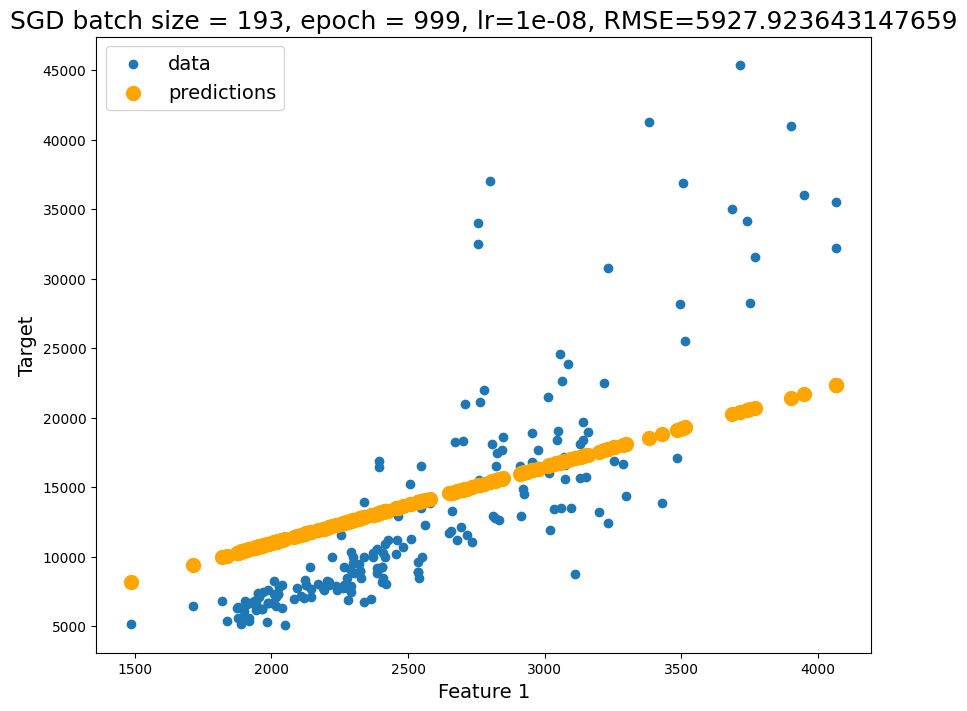

In [7]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(Data[[13]],Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [8]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,NaN
1,1,100,1.000000e-06,6.006118e+80
2,1,100,1.000000e-08,5.927937e+03
3,1,1000,1.000000e-03,NaN
4,1,1000,1.000000e-06,NaN
5,1,1000,1.000000e-08,5.927924e+03
6,10,100,1.000000e-03,NaN
7,10,100,1.000000e-06,6.006118e+80
8,10,100,1.000000e-08,5.927937e+03
9,10,1000,1.000000e-03,NaN


## Normalize the feature column and repeat the experiment.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_sc = scaler.fit_transform(Data[[13]])

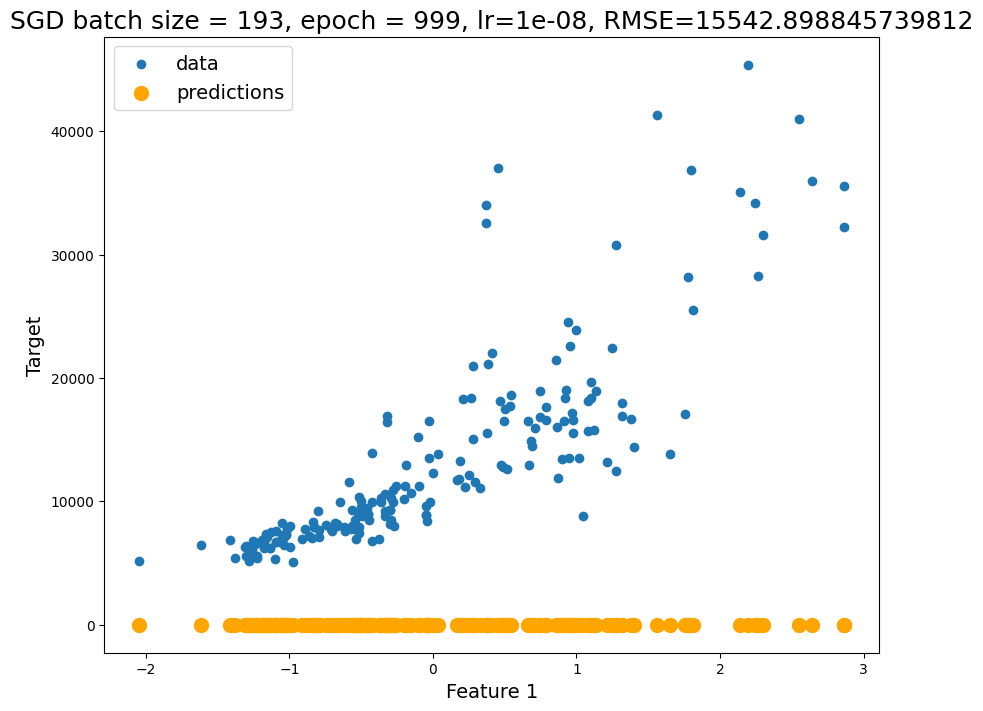

In [11]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(data_sc,Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [12]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,1.664774e+06
1,1,100,1.000000e-06,1.392910e+04
2,1,100,1.000000e-08,1.552674e+04
3,1,1000,1.000000e-03,1.113726e+07
4,1,1000,1.000000e-06,6.766481e+03
5,1,1000,1.000000e-08,1.538016e+04
6,10,100,1.000000e-03,1.664774e+06
7,10,100,1.000000e-06,1.392910e+04
8,10,100,1.000000e-08,1.552674e+04
9,10,1000,1.000000e-03,1.113726e+07


###Type the answer

ANSwer here


#3. (10pt) In this part you will use the built-in functions for Linear Regression. They are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook from Fall](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_fall/Lectures/ML9.ipynb)).

(3pt) Choose the features for prediction ([see Model Selection notebook from Week 4](https://github.com/anton-selitskiy/RIT_ML/tree/main/2025_spring/Week04_SGD/ML7.ipynb))

(3pt) Choose the model by the grid-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [ ]:
# To have the names of the columns, we upload file Description.txt
descripsion = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = descripsion[0].str.strip() #delete extra spaces in the column names
Data.head()